# Working with Text Data

## Tokenizing Text
Tokenization a short story: the verdict.

In [220]:
import urllib.request
url = ("https://raw.githubusercontent.com/rasbt/"
 "LLMs-from-scratch/main/ch02/01_main-chapter-code/"
 "the-verdict.txt")
file_path = "the-verdict.txt"
urllib.request.urlretrieve(url, file_path)

('the-verdict.txt', <http.client.HTTPMessage at 0x269f1bd4370>)

In [221]:
# Getting the file
with open("the-verdict.txt", "r", encoding="utf-8") as f:
 raw_text = f.read()
print("Total number of character:", len(raw_text))
print(raw_text[:99])

Total number of character: 20479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


In [222]:
# Splitting text into words for tokenization

import re
text = "Hello, world. This, is a test."
result = re.split(r'(\s)', text)        # Splitting by space
print(result)

['Hello,', ' ', 'world.', ' ', 'This,', ' ', 'is', ' ', 'a', ' ', 'test.']


In [223]:
# Splitting text by spaces, commas, and periods.
result = re.split(r'([,.]|\s)', text)
print(result)

['Hello', ',', '', ' ', 'world', '.', '', ' ', 'This', ',', '', ' ', 'is', ' ', 'a', ' ', 'test', '.', '']


In [224]:
# To remove whitespaces
result = [item for item in result if item.strip()]    # NOTE: it depends on our use-case whether we encode white-spaces or remove them.  
print(result)

['Hello', ',', 'world', '.', 'This', ',', 'is', 'a', 'test', '.']


In [225]:
# Modifying the regex pattern to further handle other types of punctuation
result = re.split(r'([,.:;?_!"()\']|--|\s)', text)
result = [item.strip() for item in result if item.strip()]
print(result)

['Hello', ',', 'world', '.', 'This', ',', 'is', 'a', 'test', '.']


In [226]:
# Tokenizing the text
preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', raw_text)
preprocessed = [item.strip() for item in preprocessed if item.strip()]
print(len(preprocessed))            # Number of tokens in the text

4690


In [227]:
print(preprocessed[:30])

['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow', 'enough', '--', 'so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to', 'hear', 'that', ',', 'in']


## Converting tokens into token IDs

In [228]:
all_words = sorted(set(preprocessed))       # Getting unique words
vocab_size = len(all_words)
print(vocab_size)

1130


In [229]:
# Creating a dictionary that maps words to integers, hence, getting token ids

vocab = {token:integer for integer,token in enumerate(all_words)}
for i, item in enumerate(vocab.items()):
 print(item)
 if i >= 50:
     break

('!', 0)
('"', 1)
("'", 2)
('(', 3)
(')', 4)
(',', 5)
('--', 6)
('.', 7)
(':', 8)
(';', 9)
('?', 10)
('A', 11)
('Ah', 12)
('Among', 13)
('And', 14)
('Are', 15)
('Arrt', 16)
('As', 17)
('At', 18)
('Be', 19)
('Begin', 20)
('Burlington', 21)
('But', 22)
('By', 23)
('Carlo', 24)
('Chicago', 25)
('Claude', 26)
('Come', 27)
('Croft', 28)
('Destroyed', 29)
('Devonshire', 30)
('Don', 31)
('Dubarry', 32)
('Emperors', 33)
('Florence', 34)
('For', 35)
('Gallery', 36)
('Gideon', 37)
('Gisburn', 38)
('Gisburns', 39)
('Grafton', 40)
('Greek', 41)
('Grindle', 42)
('Grindles', 43)
('HAD', 44)
('Had', 45)
('Hang', 46)
('Has', 47)
('He', 48)
('Her', 49)
('Hermia', 50)


To convert the LLM output to words from numbers, we need to convert token IDs to text. For this, we need to implement reverse vocabulary.

In [230]:
# Implementing a simple text tokenizer

class SimpleTokenizerV1:
    def __init__(self, vocab):
        self.str_to_int = vocab             # Stores vocab
        self.int_to_str = {i:s for s,i in vocab.items()}       # Creates inverse vocab 

    # Encoding text: process input into token IDs.
    def encode(self, text):
        preprocessed = re.split(r'([,.?_!"()\']|--|\s)', text)
        preprocessed = [
        item.strip() for item in preprocessed if item.strip()
        ]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids

    # Decoding text: process token IDs into text.
    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
        return text

In [231]:
tokenizer = SimpleTokenizerV1(vocab)
text = """"It's the last he painted, you know,"
 Mrs. Gisburn said with pardonable pride."""
ids = tokenizer.encode(text)
print(ids)

[1, 56, 2, 850, 988, 602, 533, 746, 5, 1126, 596, 5, 1, 67, 7, 38, 851, 1108, 754, 793, 7]


In [232]:
print(tokenizer.decode(ids))

" It' s the last he painted, you know," Mrs. Gisburn said with pardonable pride.


In [233]:
# Let's try out our tokenizer on some random text
text = "Hello, do you like tea?"
#print(tokenizer.encode(text))      # This will raise an error because the word "Hello" is not in the vocabulary

## Adding Special Context Tokens

We need to modify the tokenizer to handle unknown words by adding special context tokens. We'll introduce 2 special context tokens: `<|unk|>` (for unknown words/tokens) and `<|endoftext|>` (to signify the start or end of a text document) , and add them to our vocabulary.

As all of the text data is concatenated together while training the model, we can insert `<|endoftext|>` after each individual document, so the model knows when a particular text document ends.

In [234]:
all_tokens = sorted(list(set(preprocessed)))
all_tokens.extend(["<|endoftext|>", "<|unk|>"])
vocab = {token:integer for integer, token in enumerate(all_tokens)}

print(len(vocab.items()))

1132


In [235]:
for i, item in enumerate(list(vocab.items())[-5:]):     # Displaying the last 5 items in the vocab
    print(item)

('younger', 1127)
('your', 1128)
('yourself', 1129)
('<|endoftext|>', 1130)
('<|unk|>', 1131)


In [236]:
# Implementing a simple text tokenizer which handles unknown words

class SimpleTokenizerV2:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = { i:s for s,i in vocab.items()}

    def encode(self, text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        preprocessed = [
        item.strip() for item in preprocessed if item.strip()
        ]
        preprocessed = [item if item in self.str_to_int
        else "<|unk|>" for item in preprocessed]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids

    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        text = re.sub(r'\s+([,.:;?!"()\'])', r'\1', text)
        return text

In [237]:
text1 = "Hello, do you like tea?"
text2 = "In the sunlit terraces of the palace."
text = " <|endoftext|> ".join((text1, text2))
print(text)

Hello, do you like tea? <|endoftext|> In the sunlit terraces of the palace.


In [238]:
tokenizer = SimpleTokenizerV2(vocab)
print(tokenizer.encode(text))

[1131, 5, 355, 1126, 628, 975, 10, 1130, 55, 988, 956, 984, 722, 988, 1131, 7]


In [239]:
print(tokenizer.decode(tokenizer.encode(text)))         # We can see that it now handles unknown words

<|unk|>, do you like tea? <|endoftext|> In the sunlit terraces of the <|unk|>.


 Depending on the LLM, some researchers also consider additional special tokens
such as the following:
* `[BOS]` (beginning of sequence)—This token marks the start of a text. It signifies to
the LLM where a piece of content begins.
* `[EOS]` (end of sequence)—This token is positioned at the end of a text and
is especially useful when concatenating multiple unrelated texts, similar to
<|endoftext|>. For instance, when combining two different Wikipedia articles or books, the [EOS] token indicates where one ends and the next begins.
* `[PAD]` (padding)—When training LLMs with batch sizes larger than one, the
batch might contain texts of varying lengths. To ensure all texts have the same
length, the shorter texts are extended or “padded” using the [PAD] token, up to
the length of the longest text in the batch.

## Byte pair encoding (BPE)

The BPE tokenizer was used to train models like GPT-2, GPT-3, GPT-3.5 etc. BPE tokenizer breaks down words into subword units.

In [240]:
# Implementing BPE is complex, so we will use an existing implementation
!pip install tiktoken

In [241]:
from importlib.metadata import version
import tiktoken
print("tiktoken version:", version("tiktoken"))

tiktoken version: 0.8.0


In [242]:
tokenizer = tiktoken.get_encoding("gpt2")       # Getting the GPT-2 tokenizer

In [243]:
text = (
 "Hello, do you like tea? <|endoftext|> In the sunlit terraces"
 "of someunknownPlace."
)
integers = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
print(integers)

[15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 1659, 617, 34680, 27271, 13]


In [244]:
strings = tokenizer.decode(integers)
print(strings)

Hello, do you like tea? <|endoftext|> In the sunlit terracesof someunknownPlace.


**NOTE:** See how it decodes unknown words like 'terracesof' and 'someunknownPlace' perfectly despite it not being present in the tokenizer.

**How does the tokenizer handle unknown words without losing info?**

The algorithm underlying BPE breaks down words that aren’t in its predefined vocabulary into smaller subword units or even individual characters, enabling it to handle out-of-vocabulary words. So, if the tokenizer encounters an unknown word during tokenization, it can represent it as a sequence of subword tokens or characters.

This ensures that the tokenizer, and therefore the LLM can process any text, even if it contains words that were not present in the training data.

**Exercise 2.1 Byte pair encoding of unknown words**

Try the BPE tokenizer from the tiktoken library on the unknown words “Akwirw ier” and
print the individual token IDs. Then, call the decode function on each of the resulting
integers in this list to reproduce the mapping shown in figure 2.11. Lastly, call the
decode method on the token IDs to check whether it can reconstruct the original
input, “Akwirw ier.”

In [245]:
text = ("Akwirw ier")
integers = tokenizer.encode(text)
print(integers)

[33901, 86, 343, 86, 220, 959]


In [246]:
strings = tokenizer.decode(integers)
print(strings)

Akwirw ier


**How does BPE know which subword tokens to introduce?**

For example, BPE starts with adding all individual single characters to its vocabulary (“a,” “b,” etc.). In the next stage, it merges character combinations that frequently occur together into subwords. For example, “d” an “e” may be merged into the subword “de,” which is common in many English words like “define,” “depend”, “made,” and “hidden.” The merges are determined by a frequency cutoff.

## Data sampling with a sliding window

The next step in creating the embeddings for the LLM is to generate the input–target
pairs required for training an LLM.

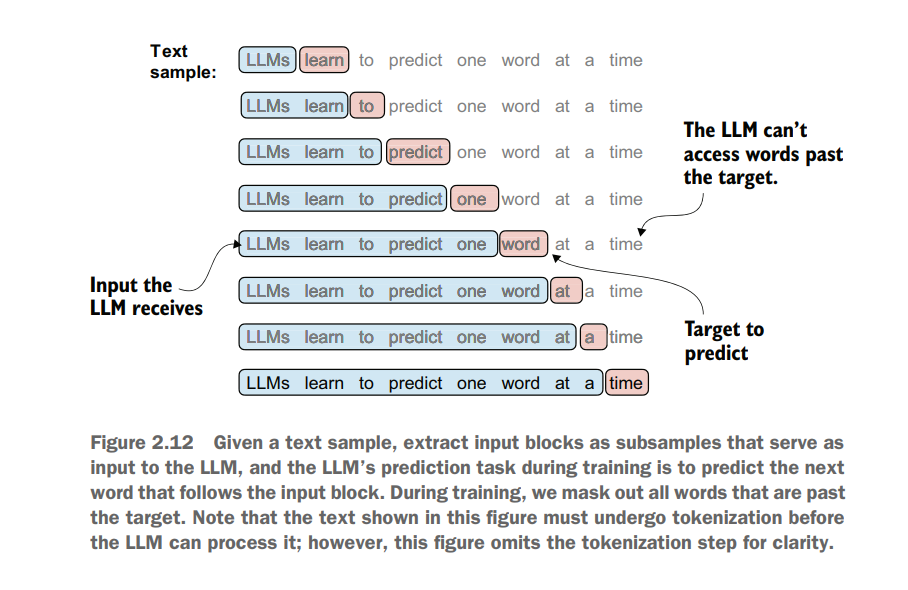

In [247]:
# Let’s implement a data loader that fetches the input–target pairs using a sliding window approach.

with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()
    
enc_text = tokenizer.encode(raw_text)
print(len(enc_text))

5145


In [248]:
enc_sample = enc_text[50:]      # Removing the first 50 tokens for demonstration purposes

In [249]:
# Sliding window approach

context_size = 4                # Number of tokens in the context
x = enc_sample[:context_size]
y = enc_sample[1:context_size+1]
print(f"x: {x}")
print(f"y:\t{y}")

x: [290, 4920, 2241, 287]
y:	[4920, 2241, 287, 257]


In [250]:
for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]
    print(context, "---->", desired)
    
# Everything on LHS of arrow is context (what the LLM can read), and RHS is desired output (what the LLM should predict).

[290] ----> 4920
[290, 4920] ----> 2241
[290, 4920, 2241] ----> 287
[290, 4920, 2241, 287] ----> 257


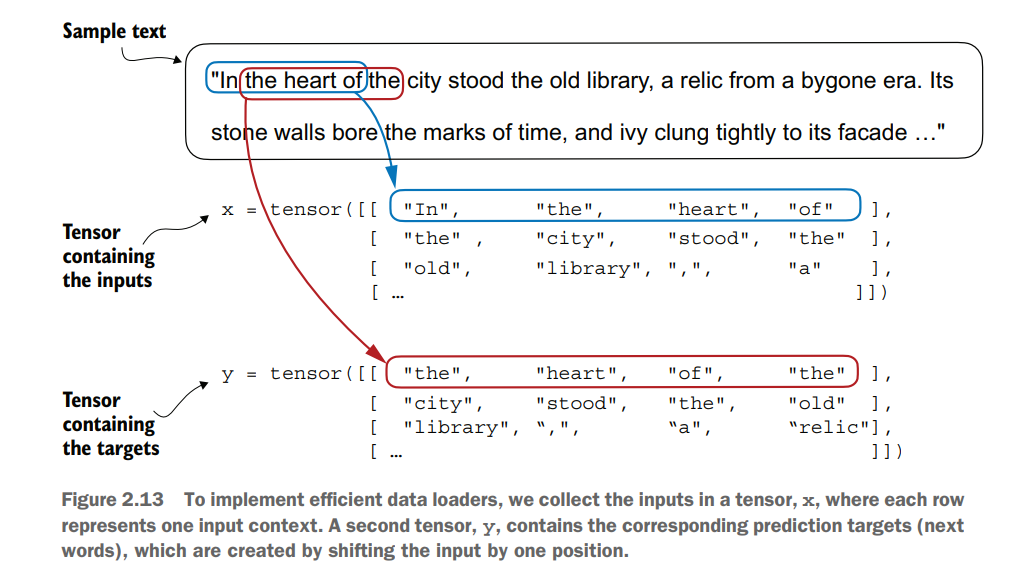

In [251]:
# !pip install torch

In [252]:
# A dataset for batched inputs and targets

import torch
from torch.utils.data import Dataset, DataLoader

class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):   
        self.input_ids = []
        self.target_ids = []
        
        token_ids = tokenizer.encode(txt)

        for i in range(0, len(token_ids) - max_length, stride):     # Uses a sliding window to chunk the book into overlapping sequences of max_length
            input_chunk = token_ids[i:i+max_length]
            output_chunk = token_ids[i+1:i+max_length+1]
            self.input_ids.append(input_chunk)
            self.target_ids.append(output_chunk)
        
    def __len__(self):          # Total number of rows in dataset
        return len(self.input_ids)
    
    def __getitem__(self, idx):    # Returns a single row
        input_tensor = torch.tensor(self.input_ids[idx], dtype=torch.long)
        target_tensor = torch.tensor(self.target_ids[idx], dtype=torch.long)
        return input_tensor, target_tensor

In [253]:
# A data loader to generate batches with input-with pairs

def create_dataloader_v1(txt, batch_size=4, max_length=256,
    stride=128, shuffle=True, drop_last=True,
    num_workers=0):
    tokenizer = tiktoken.get_encoding("gpt2")
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)
    dataloader = DataLoader(
        dataset,                        # Dataset object
        batch_size=batch_size,          # Number of sequences in a batch
        shuffle=shuffle,                # Shuffle the dataset
        drop_last=drop_last,            # Drop the last batch if it is smaller than batch_size
        num_workers=num_workers         # Number of CPU processes to use
    )
    return dataloader

In [254]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()
    
dataloader = create_dataloader_v1(
    raw_text, batch_size=1, max_length=4, stride=1, shuffle=False       # Using a batch size of 1 for demonstration purposes, normally it's something like 256
)

data_iter = iter(dataloader)    # Convert dataloader into Python iterator to fetch the next entry via the built-in next() function
first_batch = next(data_iter)
print(first_batch)
# the first tensor stores the input token IDs, and the second tensor stores the target token IDs

[tensor([[  40,  367, 2885, 1464]]), tensor([[ 367, 2885, 1464, 1807]])]


In [255]:
second_batch = next(data_iter)
print(second_batch)         # The second batch's tokens are shifted by 1 position as stride = 1, if it was set to 2, the tokens would be shifted by 2 positions

[tensor([[ 367, 2885, 1464, 1807]]), tensor([[2885, 1464, 1807, 3619]])]


**Exercise 2.2 Data loaders with different strides and context sizes**

To develop more intuition for how the data loader works, try to run it with different
settings such as max_length=2 and stride=2, and max_length=8 and stride=2.

In [256]:
dataloader_1 = create_dataloader_v1(
    raw_text, batch_size=1, max_length=4, stride=2, shuffle=False       # stride = 2
)

data_iter = iter(dataloader_1)    
first_batch = next(data_iter)
print(first_batch)
second_batch = next(data_iter)
print(second_batch)

# Jumps 2 tokens in each iteration as stride = 2

[tensor([[  40,  367, 2885, 1464]]), tensor([[ 367, 2885, 1464, 1807]])]
[tensor([[2885, 1464, 1807, 3619]]), tensor([[1464, 1807, 3619,  402]])]


In [257]:
dataloader_2 = create_dataloader_v1(
    raw_text, batch_size=1, max_length=2, stride=1, shuffle=False       # max_length = 2
)

data_iter = iter(dataloader_2)    
first_batch = next(data_iter)
print(first_batch)
second_batch = next(data_iter)
print(second_batch)

# The max length is 2, so each batch contains 2 sequences

[tensor([[ 40, 367]]), tensor([[ 367, 2885]])]
[tensor([[ 367, 2885]]), tensor([[2885, 1464]])]


In [258]:
dataloader_3 = create_dataloader_v1(
    raw_text, batch_size=2, max_length=4, stride=1, shuffle=False       # batch_size = 2
)

data_iter = iter(dataloader_3)    
first_batch = next(data_iter)
print(first_batch)
second_batch = next(data_iter)
print(second_batch)

# The batch size is 2, so takes 2 batches in each iteration

[tensor([[  40,  367, 2885, 1464],
        [ 367, 2885, 1464, 1807]]), tensor([[ 367, 2885, 1464, 1807],
        [2885, 1464, 1807, 3619]])]
[tensor([[2885, 1464, 1807, 3619],
        [1464, 1807, 3619,  402]]), tensor([[1464, 1807, 3619,  402],
        [1807, 3619,  402,  271]])]


In [259]:
dataloader = create_dataloader_v1(
    raw_text, batch_size=8, max_length=4, stride=4,     # As max_length = stride = 4, there's no overlap between sequences as more overlap increases overfitting
    shuffle=False
)
data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Inputs:\n", inputs)
print("\nTargets:\n", targets)


Inputs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Targets:
 tensor([[  367,  2885,  1464,  1807],
        [ 3619,   402,   271, 10899],
        [ 2138,   257,  7026, 15632],
        [  438,  2016,   257,   922],
        [ 5891,  1576,   438,   568],
        [  340,   373,   645,  1049],
        [ 5975,   284,   502,   284],
        [ 3285,   326,    11,   287]])


## Creating token embeddings

The last step in preparing the input text for LLM training is to convert the token IDs into embedding vectors.

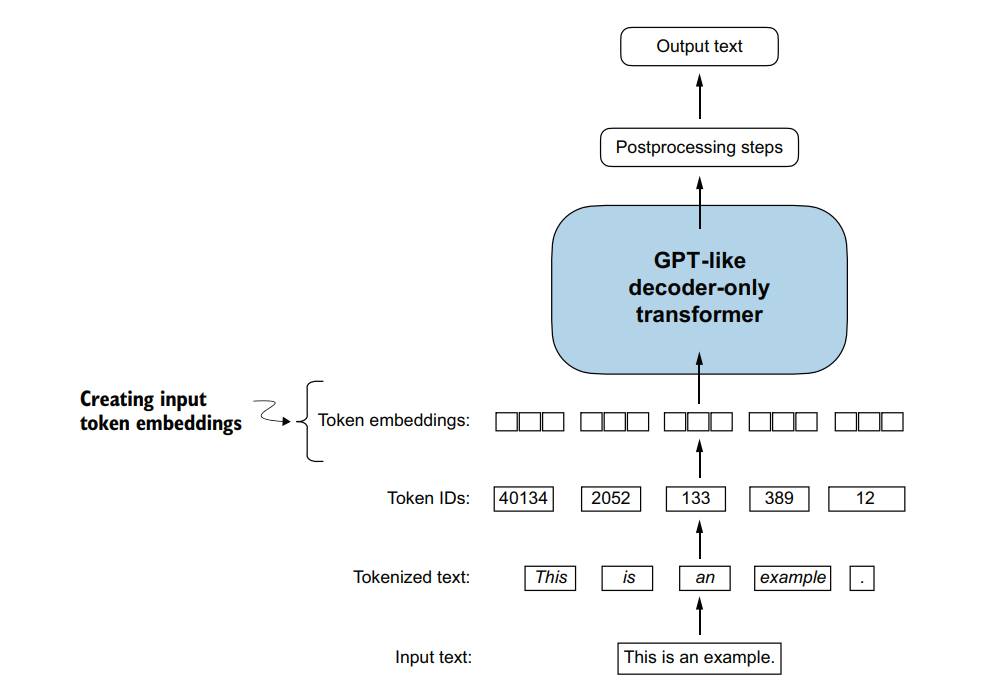

We initialize the embeddings weights with random values, this initialization is the starting point for the LLM's learning process. An embedding is necessary as GPT-like LLMs are deep neural networks trained with the backpropagation algorithm.

In [260]:
vocab_size, output_dim = 6, 3       # For simplicity

torch.manual_seed(123)
embedding_layer = torch.nn.Embedding(vocab_size, output_dim)
print(embedding_layer.weight)           # These values are optimized during LLM training

# Weight matrix is 6 rows and 3 columns, there is 1 row for each of the 6 tokens in the vocabulary and 1 column for each of the 3 embedding dimensions

Parameter containing:
tensor([[ 0.3374, -0.1778, -0.1690],
        [ 0.9178,  1.5810,  1.3010],
        [ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096]], requires_grad=True)


In [261]:
print(embedding_layer(torch.tensor([3])))     # Embedding for token with ID 3 (identical with 4th row of prev matrix)

tensor([[-0.4015,  0.9666, -1.1481]], grad_fn=<EmbeddingBackward0>)


In [262]:
input_ids = torch.tensor([2, 3, 5, 1])
print(embedding_layer(input_ids))

tensor([[ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-2.8400, -0.7849, -1.4096],
        [ 0.9178,  1.5810,  1.3010]], grad_fn=<EmbeddingBackward0>)


Each row in this output matrix is obtained via a lookup operation from the embedding weight matrix.
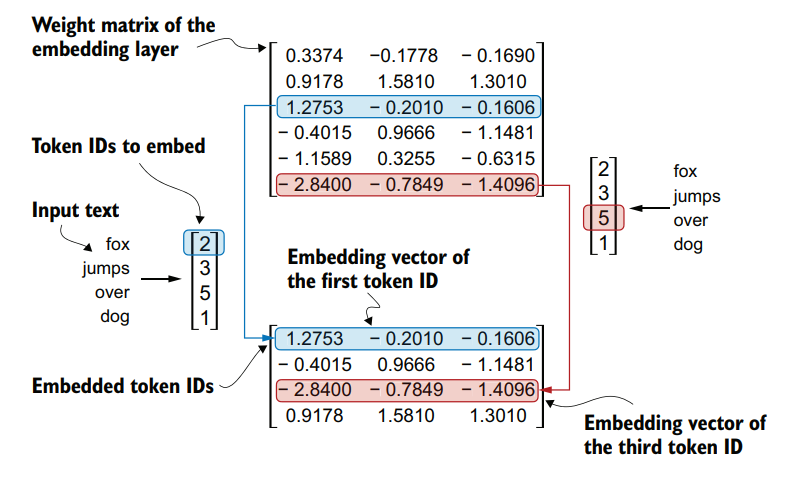

## Encoding word positions

While token embeddings are a suitable input for an LLM, a minor shortcoming of LLMs is that their self-attention mechanism doesn't have a notion of position or order for the tokens within a sequence.

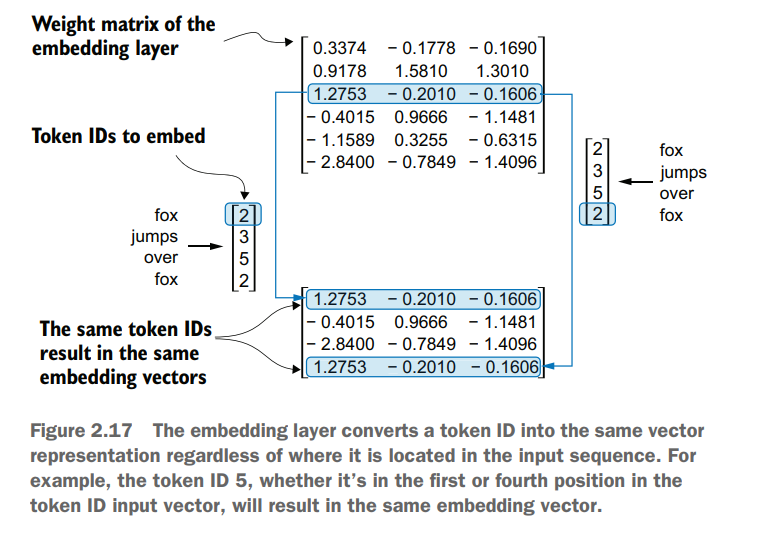

As the position of a word affects its meaning, and both self-attention and the embeddings are position-agnostic, it is helpful to add additional positional information into the LLM.

Positional embeddings are added to the token embedding vector to create the input embeddings for an LLM. The positional vectors have the same dimension as the original token embeddings. The token embeddings are shown with value 1 for simplicity.

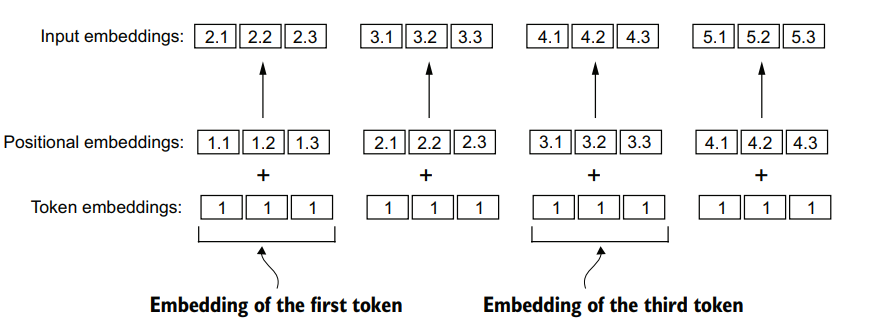

In [263]:
vocab_size = 50257      # BPE vocabulary size
output_dim = 256        # Embedding dimension
token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

If we have a batch size of 8 with 4 tokens each, and embedding size of 256, the result will be an 8 x 4 x 256 tensor.

In [264]:
max_length = 4
dataloader = create_dataloader_v1(
    raw_text, batch_size=8, max_length=max_length,
    stride=max_length, shuffle=False
)

data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Token IDs:\n", inputs)
print("\nInputs shape:\n", inputs.shape)        # Batch contains 8 samples of 4 tokens each

Token IDs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Inputs shape:
 torch.Size([8, 4])


In [265]:
token_embeddings = token_embedding_layer(inputs)        # Embedding the input tokens
print(token_embeddings.shape)           # Each token ID is now embedded as a 256 dimensional vector

torch.Size([8, 4, 256])


To follow GPT-3's absolute embedding approach, we just need to create another embedding layer that has the same embedding dimension as the `token_embeddings` layer.

In [266]:
context_length = max_length         # context length gives the supported input length
# In practice, input length can be greater than context length, in which case, input should be truncated

pos_embedding_layer = torch.nn.Embedding(context_length, output_dim)    # Positional embedding layer
pos_embeddings = pos_embedding_layer(torch.arange(context_length))      # Positional embeddings for the first 4 tokens
print(pos_embeddings.shape)

torch.Size([4, 256])


In [ ]:
input_embeddings = token_embeddings + pos_embeddings        # Adding token and positional embeddings
print(input_embeddings.shape)

torch.Size([8, 4, 256])


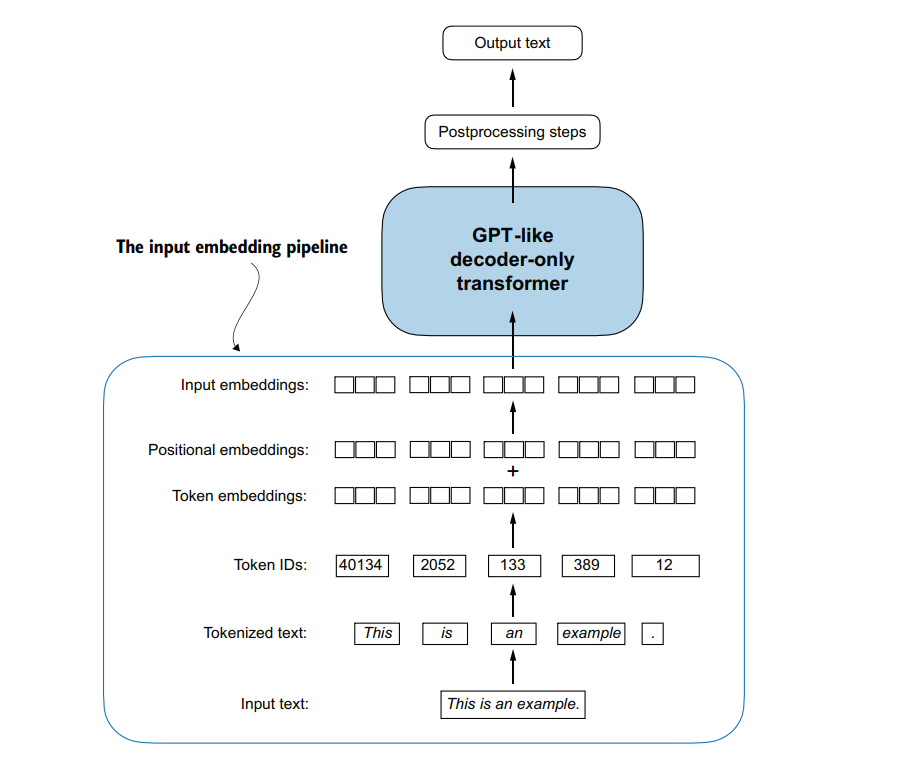